In [1]:
#requirements

import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transform
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/Kaggle/Covid19-dataset'

In [5]:
os.listdir(data_dir)

['train', 'test']

In [6]:
data_dir

'/content/drive/MyDrive/Kaggle/Covid19-dataset'

In [7]:
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"

In [8]:
os.listdir(train_dir)

['Viral Pneumonia', 'Covid', 'Normal']

In [9]:
os.listdir(test_dir)

['Covid', 'Viral Pneumonia', 'Normal']

In [10]:
dataset = ImageFolder(data_dir)
dataset

Dataset ImageFolder
    Number of datapoints: 317
    Root location: /content/drive/MyDrive/Kaggle/Covid19-dataset

In [11]:
train_folder = ImageFolder(train_dir)
test_folder = ImageFolder(test_dir)

In [12]:
train_folder

Dataset ImageFolder
    Number of datapoints: 251
    Root location: /content/drive/MyDrive/Kaggle/Covid19-dataset/train

In [13]:
test_folder

Dataset ImageFolder
    Number of datapoints: 66
    Root location: /content/drive/MyDrive/Kaggle/Covid19-dataset/test

In [14]:
classes = train_folder.classes
classes

['Covid', 'Normal', 'Viral Pneumonia']

- There are 70 files of Normal in train set.
- There are 111 files of Covid in train set.
- There are 70 files of Viral Pneumonia in train set.

## Visualize images

In [15]:
%matplotlib inline

`<PIL.Image.Image>`, is a PIL image object, and `1` is the label of the image. In this case, `Normal` is the class label for the 112th image.

(1600, 1264)


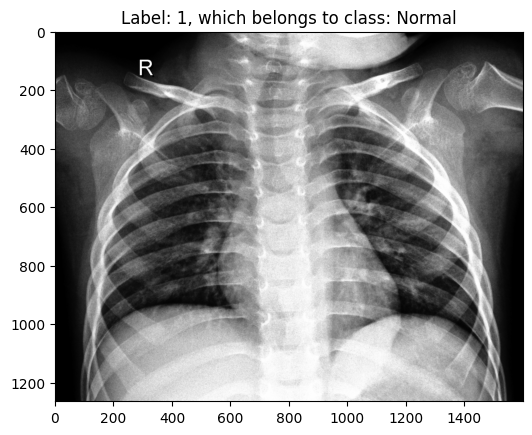

In [16]:
img, label = train_folder[112]

plt.imshow(img)
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

(1336, 1024)


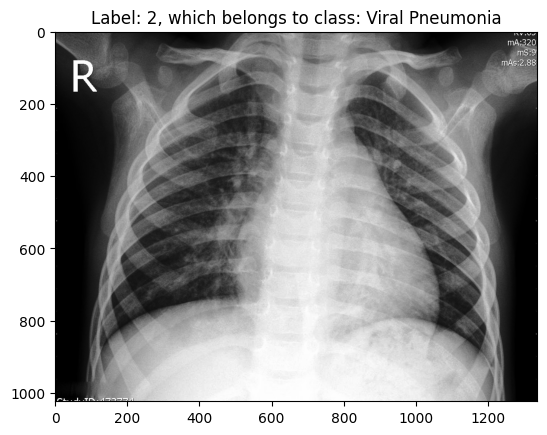

In [17]:
img, label = train_folder[200]

plt.imshow(img)
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

(1695, 1570)


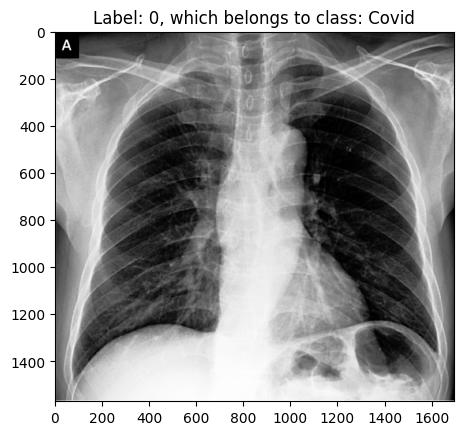

In [18]:
img, label = train_folder[29]
plt.imshow(img)
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

## Transformation and Augmentation

In [19]:
train_set = ImageFolder(train_dir, transform.Compose([
    transform.Resize((250, 250)),            # Resize image to 256x256
    transform.RandomHorizontalFlip(p=0.5),   # Randomly flip the image horizontally
    transform.ToTensor(),                    # Convert the image to a PyTorch tensor
    transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))


test_set = ImageFolder(test_dir, transform.Compose([
    transform.Resize((250, 250)),
    transform.RandomHorizontalFlip(p=0.5),
    transform.ToTensor(),
    transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [20]:
train_set

Dataset ImageFolder
    Number of datapoints: 251
    Root location: /content/drive/MyDrive/Kaggle/Covid19-dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Visualize transformed images

<built-in method size of Tensor object at 0x78d75951e020>


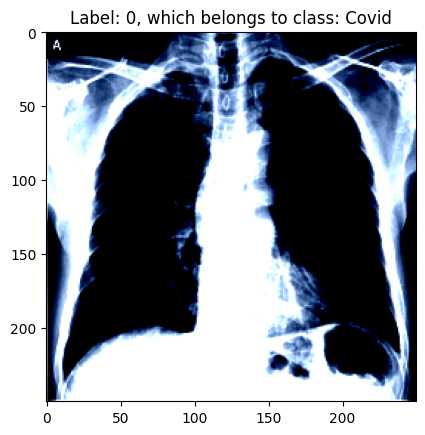

In [21]:
img, label = train_set[29]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

<built-in method size of Tensor object at 0x78d759318220>


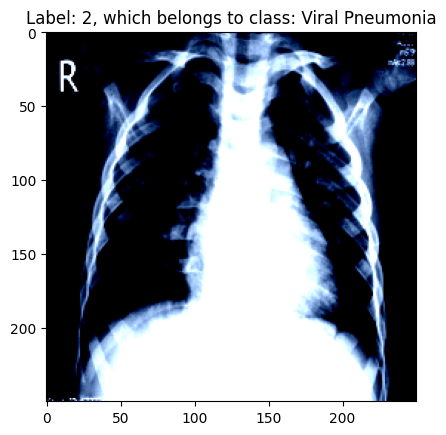

In [22]:
img, label = train_set[200]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

<built-in method size of Tensor object at 0x78d75939d530>


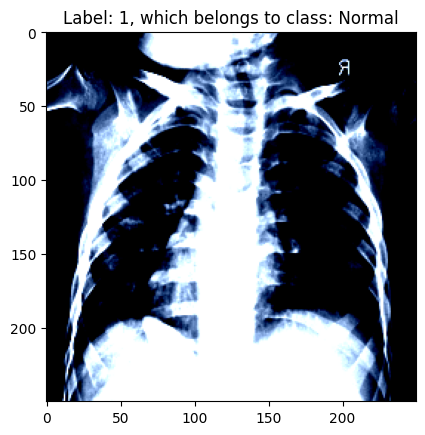

In [23]:
img, label = train_set[112]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}, which belongs to class: {classes[label]}")
print(img.size)

In [24]:
len(train_set)

251

In [25]:
val_pct = 0.25
val_size = int(val_pct * len(train_set))
train_size = int(len(train_set) - val_size)
val_size, train_size

(62, 189)

In [26]:
train_ds, val_ds = random_split(train_set, [train_size, val_size])
len(train_ds), len(val_ds)

(189, 62)

In [27]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

## Visualize a batch of data

In [28]:
def visualize_batch(images, labels):
  grid_img = torchvision.utils.make_grid(images, nrow=8, padding=2)

  np_img = grid_img.numpy().transpose((1, 2, 0))

  plt.figure(figsize=(15, 15))
  plt.imshow(np_img)
  plt.title("Batch of images with labels")
  plt.axis("off")
  plt.show()

  for i in range(len(images)):
    img = images[i]
    label = labels[i].item()

    img = img.permute(1, 2, 0).numpy()

    plt.figure()
    plt.imshow(img)
    plt.title(f"Label: {label}, which is {classes[label]}")
    plt.axis("off")
    plt.show()

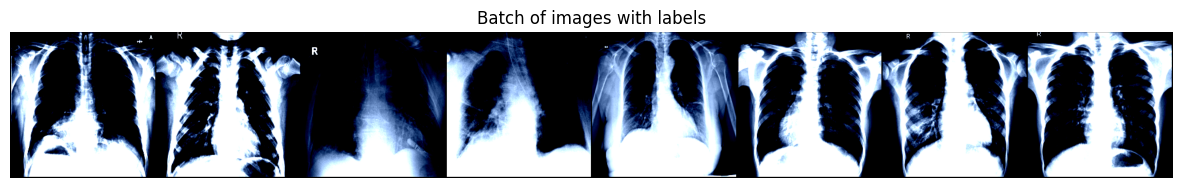

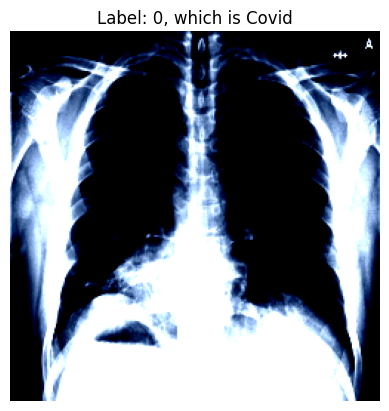

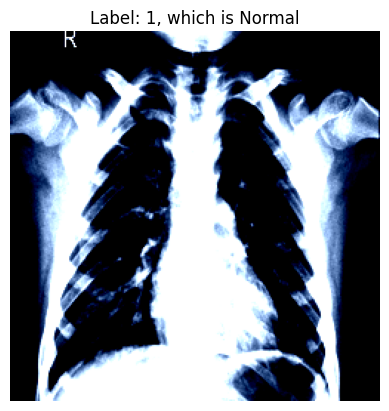

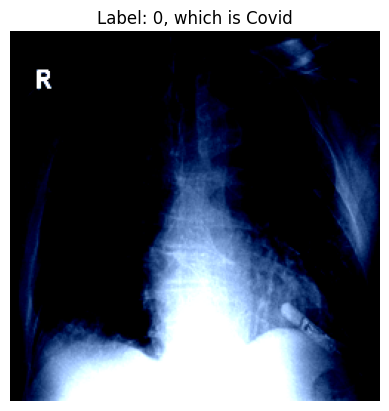

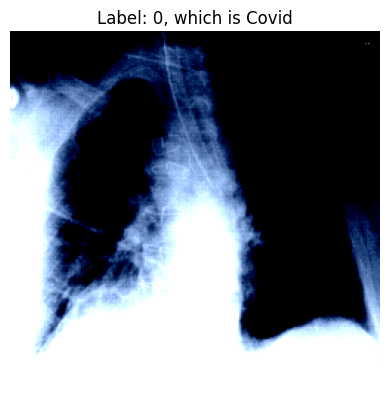

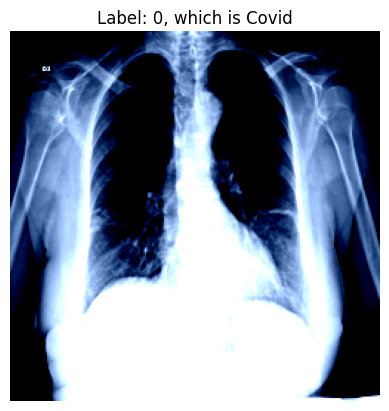

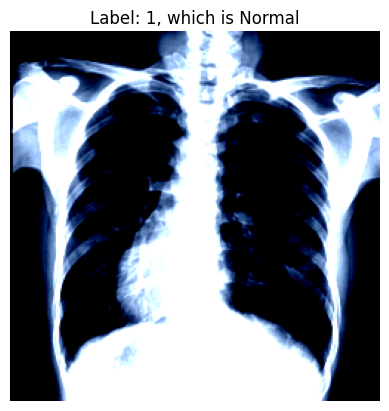

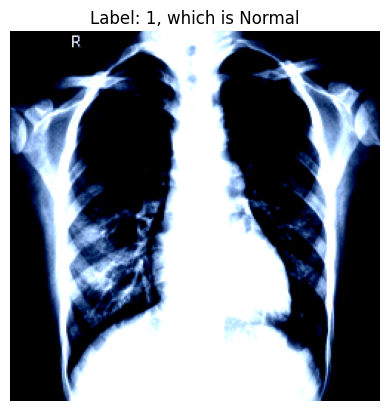

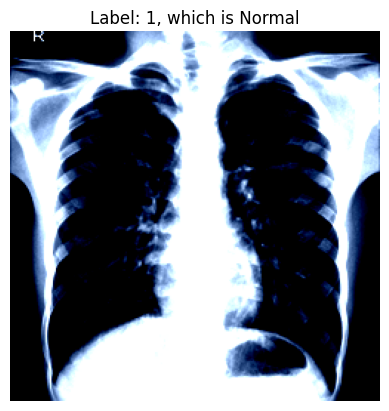

In [29]:
for batch in train_dl:
  images, labels = batch
  visualize_batch(images, labels)
  break

## Define the model

In [30]:
# class Covid19Model0(nn.Module):
#   def __init__(self):
#     super(Covid19Model0, self).__init__()

#     # Convolutional layers
#     self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#     self.dropout1 = nn.Dropout(0.5)  # Dropout after conv1
#     self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#     self.dropout2 = nn.Dropout(0.5)  # Dropout after conv2
#     self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#     self.dropout3 = nn.Dropout(0.5)  # Dropout after conv3

#     # Pooling layer
#     self.pool = nn.MaxPool2d(2, 2)

#     # Fully connected layers
#     self.linear1 = nn.Linear(128 * 31 * 31, 256)
#     self.dropout4 = nn.Dropout(0.5)  # Dropout after linear1
#     self.linear2 = nn.Linear(256, 128)
#     self.dropout5 = nn.Dropout(0.5)  # Dropout after linear2
#     self.linear3 = nn.Linear(128, 64)
#     self.dropout6 = nn.Dropout(0.5)  # Dropout after linear3
#     self.linear4 = nn.Linear(64, 3)   # Output layer for 3 classes

#   def forward(self, x):
#     # Forward pass through the network
#     x = F.relu(self.conv1(x))
#     x = self.dropout1(x)
#     x = self.pool(x)

#     x = F.relu(self.conv2(x))
#     x = self.dropout2(x)
#     x = self.pool(x)

#     x = F.relu(self.conv3(x))
#     x = self.dropout3(x)
#     x = self.pool(x)

#     # Flatten the tensor for the fully connected layers
#     x = x.view(-1, 128 * 31 * 31)

#     x = F.relu(self.linear1(x))
#     x = self.dropout4(x)

#     x = F.relu(self.linear2(x))
#     x = self.dropout5(x)

#     x = F.relu(self.linear3(x))
#     x = self.dropout6(x)

#     x = self.linear4(x)  # Output layer
#     return x

In [31]:
# model0 = Covid19Model0()
# model0

In [32]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model0.parameters(), lr=0.0001)

## Training loop

### finding accuracy of first batch of images, step by step implementation

In [33]:
# for images, labels in train_dl:
#   outputs = model0(images)
#   loss = criterion(outputs, labels)
#   break

In [34]:
# labels

In [35]:
# labels.size()

In [36]:
# labels.size(0)

In [37]:
# outputs

In [38]:
# outputs.data

In [39]:
# torch.max(outputs.data, 1)

In [40]:
# _, predicted = torch.max(outputs.data, 1)
# print(f"{_}\n\n{predicted}")

In [41]:
# loss

In [42]:
# loss.item()

In [43]:
# example_tensor = torch.tensor([[0.2, 1.5, 0.3],
#                          [2.0, 0.5, 0.3],
#                          [0.1, 0.4, 1.2]])

# torch.max(example_tensor, 1) # returns the max from each row, and its indices

### training and evaluating loop for model0

In [44]:
# def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         # Training Phase
#         model.train()
#         total_loss_train = 0.0
#         total_correct_train = 0
#         total_images_train = 0

#         for images, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # Accumulate training metrics
#             total_loss_train += loss.item() * labels.size(0)
#             _, predicted = torch.max(outputs.data, 1)
#             total_images_train += labels.size(0)
#             total_correct_train += (predicted == labels).sum().item()

#         # Calculate training accuracy and loss
#         train_accuracy = total_correct_train / total_images_train
#         train_loss = total_loss_train / total_images_train
#         train_losses.append(train_loss)
#         train_accuracies.append(train_accuracy)

#         # Validation Phase
#         model.eval()
#         total_loss_val = 0.0
#         total_correct_val = 0
#         total_images_val = 0

#         with torch.no_grad():
#             for images, labels in val_loader:
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)

#                 # Accumulate validation metrics
#                 total_loss_val += loss.item() * labels.size(0)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total_images_val += labels.size(0)
#                 total_correct_val += (predicted == labels).sum().item()

#         # Calculate validation accuracy and loss
#         val_accuracy = total_correct_val / total_images_val
#         val_loss = total_loss_val / total_images_val
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)

#         # Print metrics after each epoch
#         print(f"Epoch [{epoch+1}/{num_epochs}]")
#         print(f"Training Accuracy: {train_accuracy*100:.2f}%, Training Loss: {train_loss:.4f}")
#         print(f"Validation Accuracy: {val_accuracy*100:.2f}%, Validation Loss: {val_loss:.4f}\n")

#         torch.save(model.state_dict(), f'/content/drive/MyDrive/models/m{epoch}.pth')


#     return train_losses, train_accuracies, val_losses, val_accuracies

In [45]:
# a, b=next(iter(train_dl))
# a.shape

In [46]:
# train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate(
#     model0, train_dl, val_dl, criterion, optimizer, num_epochs=50
# )

#### training and validation accuracy

## Visualizing images in test set

In [47]:
test_dl = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

In [48]:
test_dl

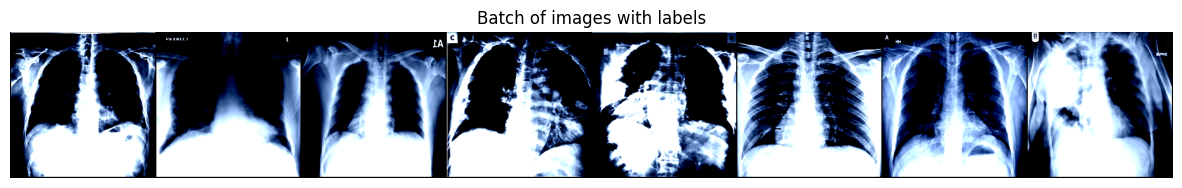

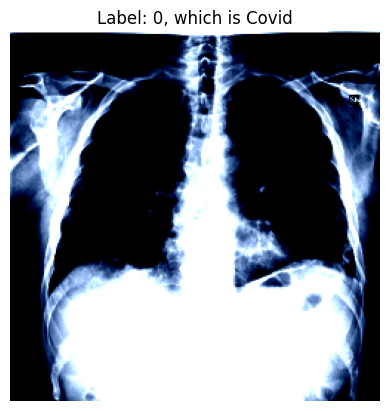

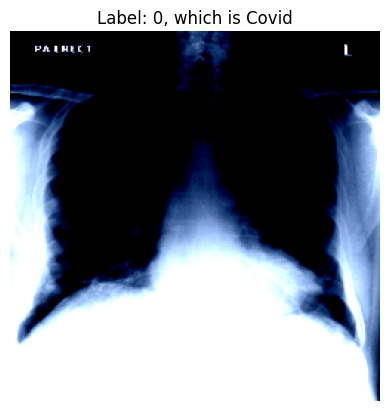

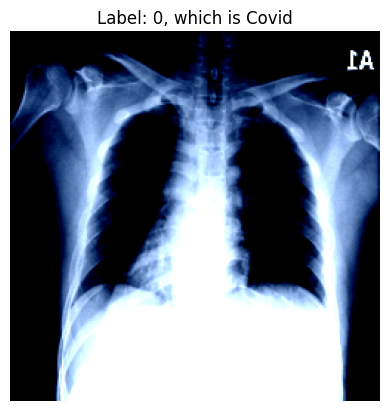

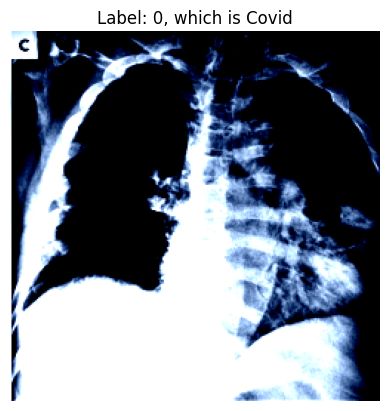

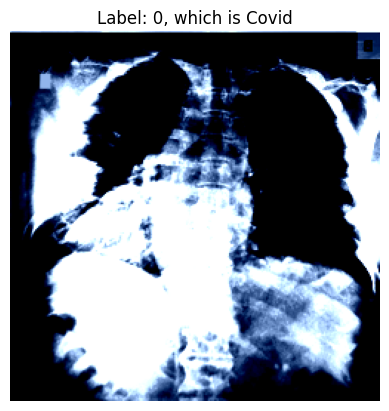

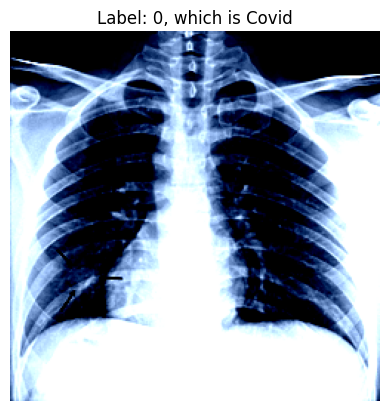

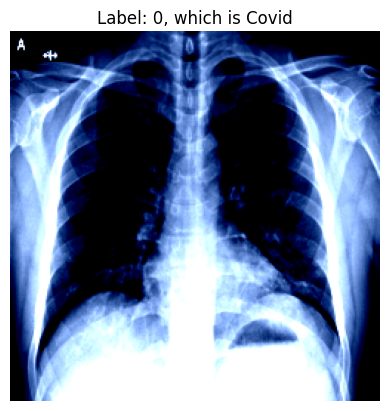

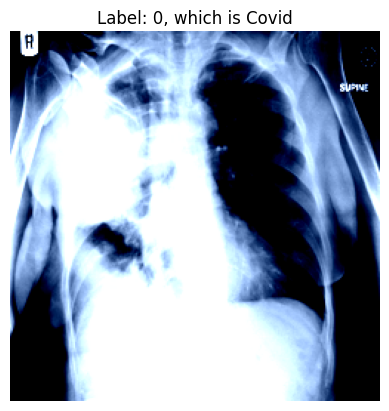

In [49]:
for images, labels in test_dl:
  visualize_batch(images, labels)
  break

## Plot predictions

In [50]:
# plt.rcParams['axes.titlesize'] = 12

# def plot_predictions(model, data_loader):
#     model.eval()

#     # Get the total number of images in the dataset
#     total_images = len(data_loader.dataset)

#     random_indices = random.sample(range(total_images), min(16, total_images))

#     selected_images = []
#     selected_labels = []

#     for idx in random_indices:
#         img, label = data_loader.dataset[idx]
#         selected_images.append(img)
#         selected_labels.append(label)

#     # Convert the list of images to a tensor for batch processing
#     selected_images = torch.stack(selected_images)
#     selected_labels = torch.tensor(selected_labels)

#     # Get the model outputs
#     outputs = model(selected_images)
#     _, predicted = torch.max(outputs.data, 1)

#     plt.figure(figsize=(20, 20))
#     num_images = selected_images.size(0)
#     for i in range(num_images):
#         plt.subplot(4, 4, i + 1)
#         img = selected_images[i].permute(1, 2, 0).numpy()

#         # Rescale the image if it's normalized
#         img = (img - img.min()) / (img.max() - img.min())

#         plt.imshow(img)
#         plt.title(f'True: {classes[selected_labels[i]]}, Predicted: {classes[predicted[i]]}')
#         plt.axis('off')

#     plt.show()

### plot predictions of train set

In [51]:
# plot_predictions(model0, train_dl)

### plot predictions of validation set

In [52]:
# plot_predictions(model0, val_dl)

### plot predictions of test set

In [53]:
# plot_predictions(model0, test_dl)

## Plot loss and accuracy curves

In [54]:
# def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
#     epochs = range(1, len(train_losses) + 1)

#     plt.figure(figsize=(12, 5))

#     # Plot loss
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, train_losses, 'b', label='Training loss')
#     plt.plot(epochs, val_losses, 'r', label='Validation loss')
#     plt.title('Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, [acc * 100 for acc in train_accuracies], 'b', label='Training accuracy')
#     plt.plot(epochs, [acc * 100 for acc in val_accuracies], 'r', label='Validation accuracy')
#     plt.title('Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy (%)')
#     plt.legend()

#     plt.show()

In [55]:
# plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies)

# Variations with optimizers, batch size, learning rate and scheduler

In [56]:
class Tuning_model(nn.Module):
  def __init__(self):
    super(Tuning_model, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.dropout1 = nn.Dropout(0.5)  # Dropout after conv1
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.dropout2 = nn.Dropout(0.5)  # Dropout after conv2
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.dropout3 = nn.Dropout(0.5)  # Dropout after conv3

    # Pooling layer
    self.pool = nn.MaxPool2d(2, 2)

    # Fully connected layers
    self.linear1 = nn.Linear(128 * 31 * 31, 256)
    self.dropout4 = nn.Dropout(0.5)  # Dropout after linear1
    self.linear2 = nn.Linear(256, 128)
    self.dropout5 = nn.Dropout(0.5)  # Dropout after linear2
    self.linear3 = nn.Linear(128, 64)
    self.dropout6 = nn.Dropout(0.5)  # Dropout after linear3
    self.linear4 = nn.Linear(64, 3)   # Output layer for 3 classes

  def forward(self, x):
    # Forward pass through the network
    x = F.relu(self.conv1(x))
    x = self.dropout1(x)
    x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.dropout2(x)
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = self.dropout3(x)
    x = self.pool(x)

    # Flatten the tensor for the fully connected layers
    x = x.view(-1, 128 * 31 * 31)

    x = F.relu(self.linear1(x))
    x = self.dropout4(x)

    x = F.relu(self.linear2(x))
    x = self.dropout5(x)

    x = F.relu(self.linear3(x))
    x = self.dropout6(x)

    x = self.linear4(x)  # Output layer
    return x

In [57]:
module_tune = Tuning_model()

In [58]:
import time
import torch
import matplotlib.pyplot as plt

def config_selection(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = Tuning_model().to(config['device'])
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    epoch_times = []  # To store time per epoch

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training Phase
        model.train()
        total_loss_train = 0.0
        total_correct_train = 0
        total_images_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_images_train += labels.size(0)
            total_correct_train += (predicted == labels).sum().item()

        train_accuracy = total_correct_train / total_images_train
        train_loss = total_loss_train / total_images_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        total_loss_val = 0.0
        total_correct_val = 0
        total_images_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_loss_val += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_images_val += labels.size(0)
                total_correct_val += (predicted == labels).sum().item()

        val_accuracy = total_correct_val / total_images_val
        val_loss = total_loss_val / total_images_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_times.append(end_time - start_time)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Acc: {train_accuracy*100:.2f}%, Train Loss: {train_loss:.4f} - "
              f"Val Acc: {val_accuracy*100:.2f}%, Val Loss: {val_loss:.4f} - "
              f"Time: {epoch_times[-1]:.2f} seconds")

    return train_losses, train_accuracies, val_losses, val_accuracies, epoch_times



Running configuration: {'device': 'cpu', 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
Epoch [1/10] - Train Acc: 31.22%, Train Loss: 1.1043 - Val Acc: 24.19%, Val Loss: 1.1051 - Time: 9.17 seconds
Epoch [2/10] - Train Acc: 28.57%, Train Loss: 1.1115 - Val Acc: 24.19%, Val Loss: 1.1051 - Time: 10.06 seconds
Epoch [3/10] - Train Acc: 26.98%, Train Loss: 1.1141 - Val Acc: 24.19%, Val Loss: 1.1049 - Time: 10.23 seconds
Epoch [4/10] - Train Acc: 20.63%, Train Loss: 1.1119 - Val Acc: 24.19%, Val Loss: 1.1052 - Time: 10.27 seconds
Epoch [5/10] - Train Acc: 32.80%, Train Loss: 1.1006 - Val Acc: 24.19%, Val Loss: 1.1050 - Time: 9.25 seconds
Epoch [6/10] - Train Acc: 36.51%, Train Loss: 1.1061 - Val Acc: 24.19%, Val Loss: 1.1050 - Time: 9.86 seconds
Epoch [7/10] - Train Acc: 28.04%, Train Loss: 1.1134 - Val Acc: 24.19%, Val Loss: 1.1051 - Time: 9.63 seconds
Epoch [8/10] - Train Acc: 25.40%, Train Loss: 1.1135 - Val Acc: 24.19%, Val Loss: 1.1051 - Time: 9.81 seconds
Epoch [9/10]

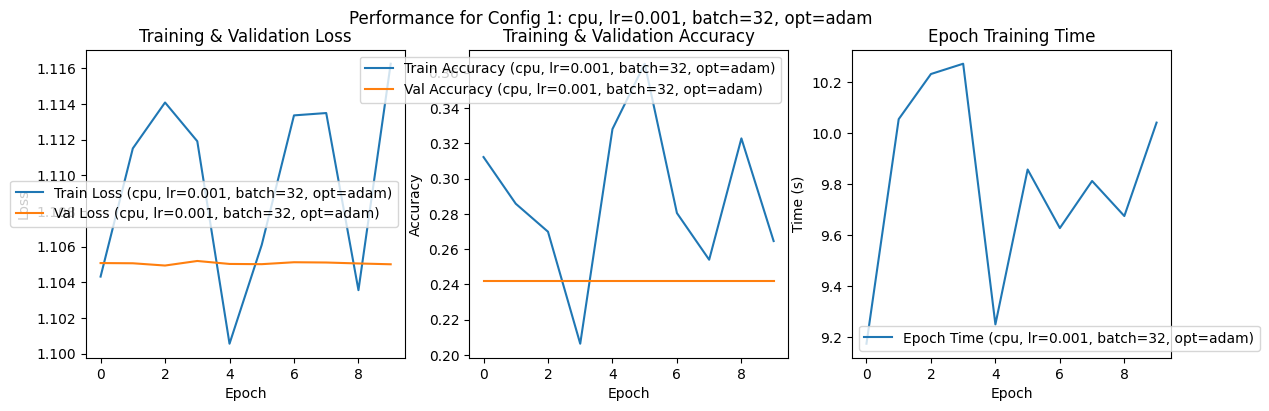

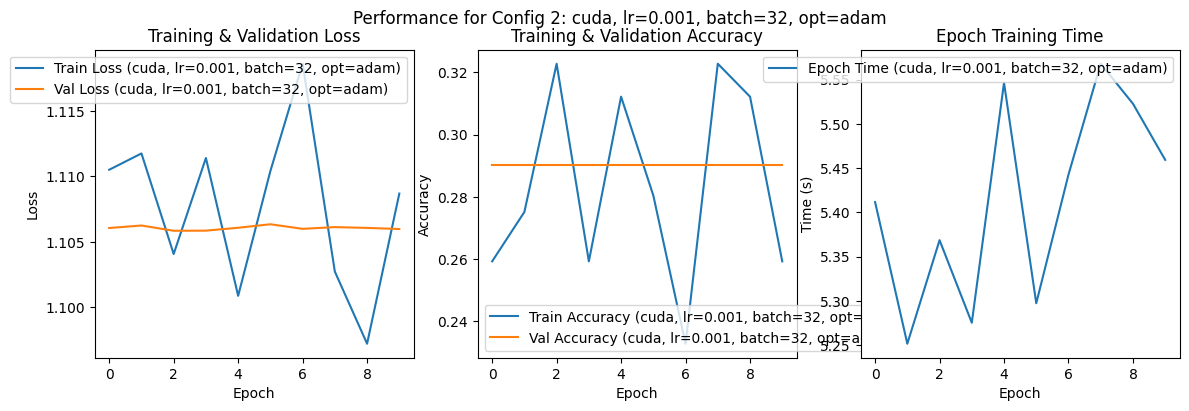

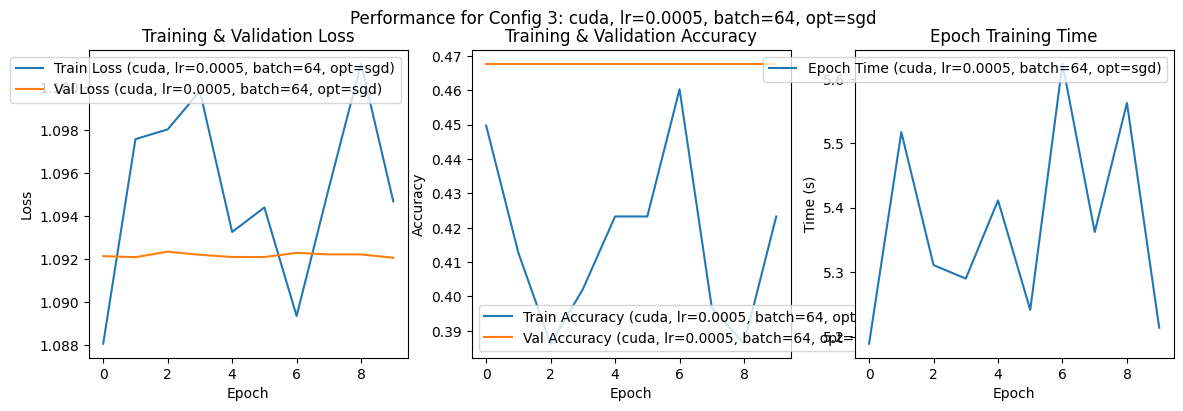

In [60]:
configs = [
    {'device': 'cpu', 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam'},
    {'device': 'cuda', 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam'},
    {'device': 'cuda', 'learning_rate': 0.0005, 'batch_size': 64, 'optimizer': 'sgd'},
    # Add more configurations as needed
]

results = []

for config in configs:
    # Setup model, criterion, and optimizer based on config
    model_tune = Tuning_model()  # Replace with your model
    criterion = torch.nn.CrossEntropyLoss()

    if config['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model_tune.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(model_tune.parameters(), lr=config['learning_rate'])
    # elif config['optimizer'] == 'adamw':
    #     optimizer = torch.optim.AdamW(model_tune.parameters(), lr=config['learning_rate'])
    # elif config['optimizer'] == 'rmsprop':
    #     optimizer = torch.optim.RMSprop(model_tune.parameters(), lr=config['learning_rate'])
    # elif config['optimizer'] == 'adagrad':
    #     optimizer = torch.optim.Adagrad(model_tune.parameters(), lr=config['learning_rate'])
    else:
        raise ValueError(f"Unsupported optimizer: {config['optimizer']}")

    print(f"\nRunning configuration: {config}")

    total_start_time = time.time()

    # Train and evaluate
    train_losses, train_accuracies, val_losses, val_accuracies, epoch_times = config_selection(
        model_tune, train_dl, val_dl, criterion, optimizer, num_epochs=10, device=config['device']
    )

    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time

    # Store results
    results.append({
        'config': config,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'epoch_times': epoch_times,
        'total_training_time': total_training_time
    })
    print('---------------------------------------------------')

# Plot Comparison Graphs
for i, result in enumerate(results):
    config = result['config']
    label = f"{config['device']}, lr={config['learning_rate']}, batch={config['batch_size']}, opt={config['optimizer']}"

    # Plot losses
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.plot(result['train_losses'], label=f"Train Loss ({label})")
    plt.plot(result['val_losses'], label=f"Val Loss ({label})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    # Plot accuracies
    plt.subplot(1, 3, 2)
    plt.plot(result['train_accuracies'], label=f"Train Accuracy ({label})")
    plt.plot(result['val_accuracies'], label=f"Val Accuracy ({label})")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Plot epoch times
    plt.subplot(1, 3, 3)
    plt.plot(result['epoch_times'], label=f"Epoch Time ({label})")
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.title('Epoch Training Time')

    plt.suptitle(f"Performance for Config {i+1}: {label}")
    plt.show()
